# Darstellung der manuellen Fälle

Hier eine Darstellung des Tageskomposits der manuellen Fälle.

In [16]:
import sys
import numpy as np
import pandas as pd
import xarray as xr

import glob
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import radar_cmap as rc
rcmap,rnorm = rc.haci_radar_cmap()

import fixed_colourbar as fc
from scipy import ndimage as ndi
from skimage.measure import find_contours
from skimage import color

sys.path.append("/vols/satellite/home/stephan/utils/tracking")
import object_tracking as ot

import operator
import seaborn as sns

In [2]:
r, rcmap = rc.haci_radar_cmap

TypeError: 'function' object is not iterable

In [17]:
def normalise2range(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def array_to_256(array):
    return (array*255.999).astype("uint8")

def day_natural_composite(vis006_data,vis008_data,nir016_data,factor=1,gamma=1):
    blue = array_to_256(np.clip(vis006_data/factor,0,1)**(1./gamma))
    green = array_to_256(np.clip(vis008_data/factor,0,1)**(1./gamma))
    red = array_to_256(np.clip(nir016_data/factor,0,1)**(1./gamma))
    
    return np.dstack([red,green,blue]).astype("uint8")

def scale_array_min_max(array_data,range_min=0,range_max=1):
    """
    Scales a array into the chosen range.
    
    Inputs:
    -------
    array_data: numpy array of floats or integers, 2d
        array to scale
    range_min: int or float, default = 0
        minimum value of the range to scale array to,
    range_max: int or float, default = 1
        maximum value of the range to scale array to,
        
    Returns:
    --------
    scaled_array: numpy array of floats, 2d
    """
    # get array extrema
    array_min = np.min(array_data)
    array_max = np.max(array_data)

    # derive conversion parameters
    a = (range_max - range_min) / (array_max - array_min)
    b = range_max - a * array_max

    # scale array
    scaled_array = a * array_data + b
    
    return scaled_array

def add_hrv_texture2nc(nc,hrv):
    nc_lab = color.rgb2lab(nc)
    l_min = nc_lab[...,0].min()
    l_max = nc_lab[...,0].max()
    
    l_hrv_scaled = nc_lab[...,0] * hrv
    l_hrv_scaled = scale_array_min_max(l_hrv_scaled,l_min,l_max)

    nc_lab[...,0] = l_hrv_scaled
    
    return color.lab2rgb(nc_lab)

In [18]:
talos_home = "/vols/talos/home/stephan"
data_path = "{talos_home}/data".format(talos_home=talos_home)
track_data_path = "{dp}/radar_track/trackdata/hires".format(dp=data_path)

In [19]:
track_paths = glob.glob("{tdp}/*.nc".format(tdp=track_data_path))

In [20]:
def get_track_id_from_file_path(file_path):
    import os
    file_name = os.path.basename(file_path)

    track_id = "{}_{}".format(file_name.split(".")[0].split("_")[-2],
                              file_name.split(".")[0].split("_")[-1])
    
    return track_id

In [6]:
import os

In [8]:
file_name = os.path.basename(track_paths[0])

In [9]:
file_name.split(".")[0].split("_")[-2]

'20130618'

In [11]:
track_id = get_track_id_from_file_path(track_paths[0])

In [12]:
track_id

'20130618_484'

In [14]:
track_example = xr.open_dataset(track_paths[0])

In [17]:
nc_rgbs = np.array([day_natural_composite(track_example.vis006.data[i],
                                          track_example.vis008.data[i],
                                          track_example.ir016.data[i],0.9,1.8) 
                    for i in xrange(len(track_example.ir108.data))])

In [25]:
rcmap

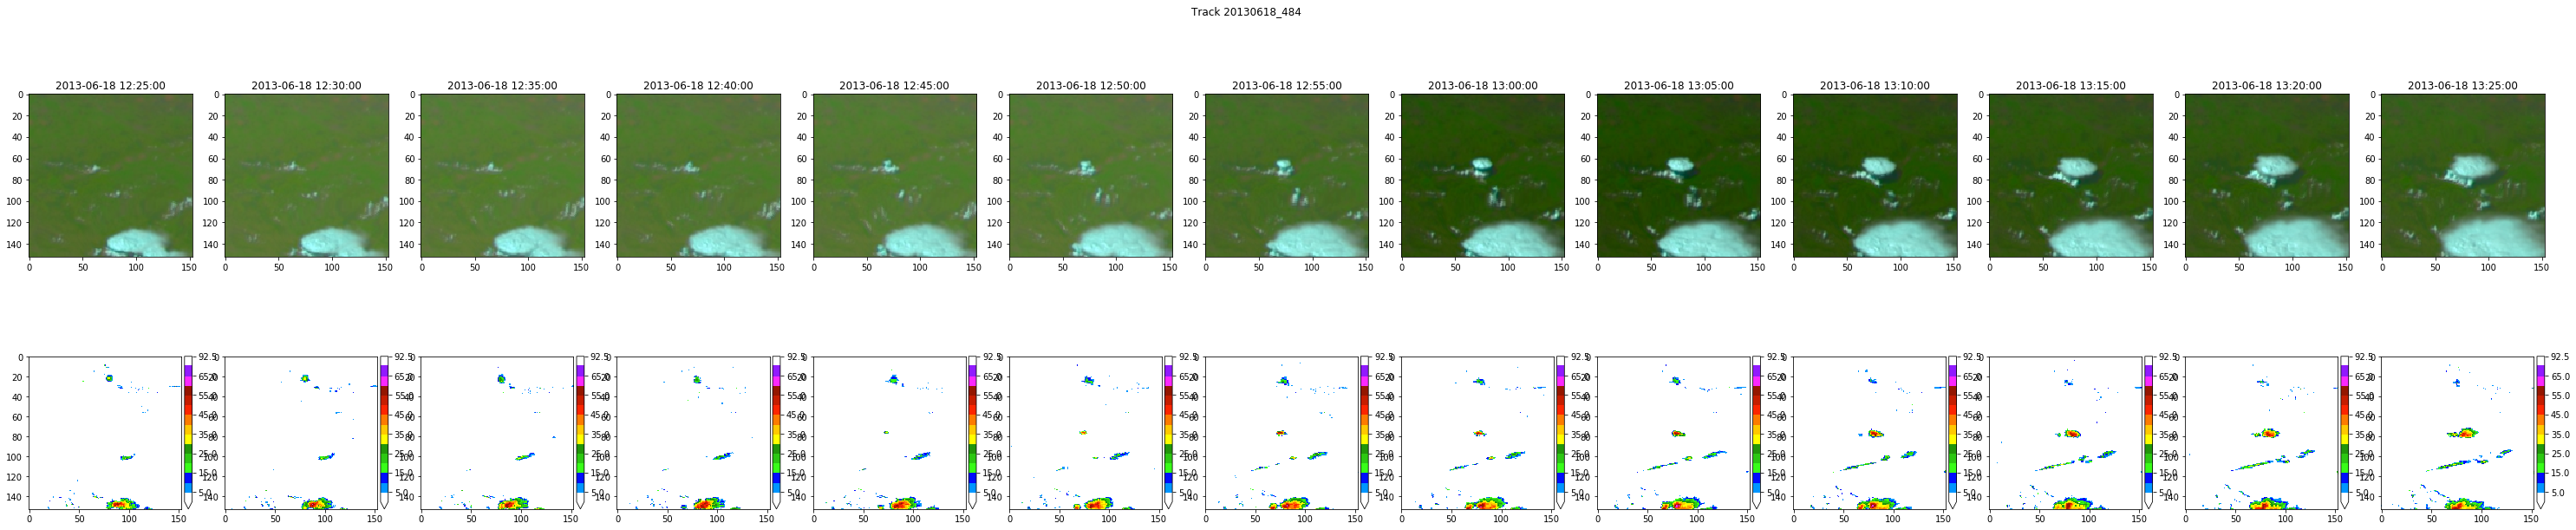

In [58]:
fig,ax = plt.subplots(2,13,figsize=(52,10))
axs=ax.ravel()
for i, n in enumerate(nc_rgbs):
    nc_plot =  ax[0,i].imshow(add_hrv_texture2nc(n,track_example.hrv.data[i]))
    ax[0,i].set_title(pd.to_datetime(track_example.time.data[i]))
    #hrv_plot = ax[1,i].imshow(track_example.hrv.data[i],vmin=0,vmax=1,cmap='gray')
    z_plot = ax[1,i].imshow(np.ma.masked_less_equal(np.ma.masked_greater_equal(track_example.z.data[i],92.5),-32.5),
                             cmap=rcmap,origin='upper',norm=rnorm)
    fc.colourbar(z_plot)
fig.suptitle('Track {}'.format(track_id))
plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/track_overview/{}.png".format(track_id))

In [42]:
hrv_segmented = ot.segmentation_dilation(track_example.hrv.data,0.3,1) 
main_track_hrv = ot.get_track_from_labeled_field(hrv_segmented)

In [43]:
rx_segmented = ot.segmentation_dilation(track_example.z.data,35,gauss_sigma=0,dilation_size=3,op=operator.ge)
main_track_rx = ot.get_track_from_labeled_field(rx_segmented)

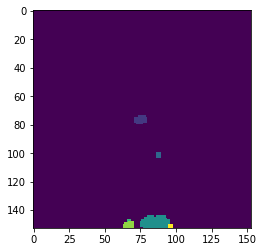

In [41]:
plt.imshow(rx_segmented[6])

In [44]:
def get_wanted_object_field(labeled_field,track):
    object_field = dict()
    
    for i, obj in enumerate(track):
        t_idx = int(obj.split("_")[0])
        oid = int(obj.split("_")[1])

        cut = np.zeros_like(labeled_field[i])

        obj_locations = np.where(labeled_field[t_idx] == oid)

        cut[obj_locations] = 1
        object_field[t_idx] = cut
        
    return object_field

In [45]:
hrv_object = get_wanted_object_field(hrv_segmented,main_track_hrv)
rx_object = get_wanted_object_field(rx_segmented,main_track_rx)

In [116]:
reload(ot)

<module 'object_tracking' from '/vols/talos/home/stephan/utils/tracking/object_tracking.py'>

In [48]:
centroids = {t:{'hrv':[],'rx':[]} for t in np.arange(0,13)}

In [49]:
for t in np.arange(0,13):
    try:
        centroids[t]['hrv'] = ndi.measurements.center_of_mass(hrv_object[t])
    except:
        centroids[t]['hrv'] = (np.nan,np.nan)
        
    try:
        centroids[t]['rx'] = ndi.measurements.center_of_mass(rx_object[t])
    except:
        centroids[t]['rx'] = (np.nan,np.nan)        

In [50]:
centroids

{0: {'hrv': (69.83962264150944, 60.79245283018868), 'rx': (nan, nan)},
 1: {'hrv': (69.67295597484276, 64.34591194968553), 'rx': (nan, nan)},
 2: {'hrv': (69.89340101522842, 65.20812182741116), 'rx': (nan, nan)},
 3: {'hrv': (69.67782426778243, 66.97489539748953), 'rx': (nan, nan)},
 4: {'hrv': (69.8125, 68.29513888888889), 'rx': (76.0, 72.0)},
 5: {'hrv': (70.22093023255815, 69.64244186046511),
  'rx': (76.44827586206897, 73.58620689655173)},
 6: {'hrv': (69.99287410926365, 71.14251781472684), 'rx': (76.5, 75.0)},
 7: {'hrv': (70.45921985815603, 72.79432624113475),
  'rx': (76.69565217391305, 76.95652173913044)},
 8: {'hrv': (70.89861111111111, 74.88055555555556),
  'rx': (76.86274509803921, 79.09803921568627)},
 9: {'hrv': (71.39771428571429, 76.78514285714286),
  'rx': (77.26027397260275, 81.54794520547945)},
 10: {'hrv': (71.2390438247012, 78.85756972111554),
  'rx': (77.32530120481928, 82.78313253012048)},
 11: {'hrv': (70.86944937833037, 80.67495559502665),
  'rx': (77.4105263157

In [61]:
distances = dict()

for t in centroids.keys():
    try:
        d = np.sqrt(((centroids[t]['hrv'][0] - centroids[t]['rx'][0])*2)**2 + \
                    (centroids[t]['hrv'][1] - centroids[t]['rx'][1])**2)
        distances[t] = d
    except:
        distances[t] = np.nan

In [62]:
distances

{0: nan,
 1: nan,
 2: nan,
 3: nan,
 4: 12.917686358346973,
 5: 13.064173032282199,
 6: 13.573905784307808,
 7: 13.149000854802965,
 8: 12.651906784338605,
 9: 12.65554070510776,
 10: 12.789845931660404,
 11: 13.426162101927888,
 12: 13.93576536914566}

In [78]:
obj_idx = np.where(hrv_object[0]!=0)

{'boxes': [<matplotlib.lines.Line2D at 0x7f9f1909e590>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9f190b9290>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9eec7fcfd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9f190d6490>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9f1909e510>,
  <matplotlib.lines.Line2D at 0x7f9f1909ed10>]}

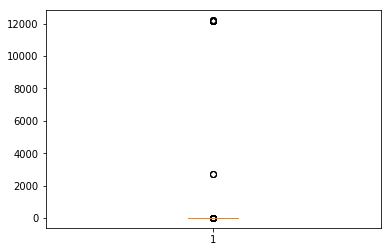

In [95]:
plt.boxplot(track_example.cth.data[0][obj_idx])

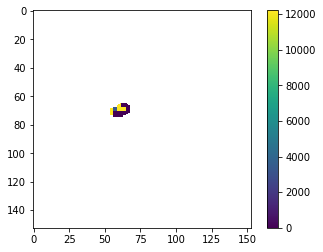

In [97]:
plt.imshow(np.ma.masked_where(hrv_object[0]<1,track_example.cth.data[0]))
plt.colorbar()

In [98]:
obj_idx = np.where(hrv_object[0]!=0)
    
ct = track_example.ct.data[0][obj_idx]
not_cirrus_idx = np.where(ct<11)

In [99]:
obj_idx

(array([65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67,
        67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69,
        69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71,
        71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72,
        72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74,
        74, 74, 74, 74]),
 array([61, 62, 63, 64, 65, 60, 61, 62, 63, 64, 65, 66, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 54, 55, 56, 57, 58, 59, 60,
        61, 62, 63, 64, 65, 66, 67, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 56, 57, 58,
        59, 60, 61, 62]))

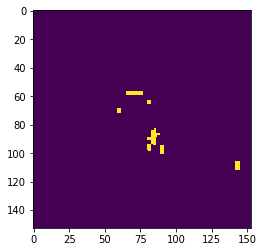

In [104]:
plt.imshow(track_example.ct.data[7])

In [105]:
track_example

<xarray.Dataset>
Dimensions:  (time: 13, x: 153, y: 153)
Coordinates:
    lat      (x, y) float64 51.73 51.73 51.73 51.73 51.73 51.73 51.73 51.73 ...
    lon      (x, y) float64 12.14 12.16 12.17 12.19 12.21 12.22 12.24 12.25 ...
  * time     (time) datetime64[ns] 2013-06-18T12:25:00 2013-06-18T12:30:00 ...
Dimensions without coordinates: x, y
Data variables:
    ir016    (time, x, y) float64 0.1926 0.194 0.1967 0.1995 0.2022 0.2008 ...
    ctp      (time, x, y) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    ir134    (time, x, y) float64 264.1 264.1 264.0 263.9 263.9 263.9 263.9 ...
    ir039    (time, x, y) float64 297.1 297.7 298.7 299.7 300.6 300.8 300.5 ...
    hrv      (time, x, y) float64 0.2088 0.2088 0.2003 0.1875 0.1719 0.1705 ...
    cma      (time, x, y) float64 0.0 0.0 1.597e-22 1.614e-22 1.495e-22 0.0 ...
    wv062    (time, x, y) float64 231.9 231.9 231.9 231.9 231.8 231.7 231.7 ...
    ir120    (time, x, y) float64 289.9 290.0 290.3 290.6 290.7 290.7 290.6 ...
 

In [111]:
cth = []
t_idx =[]
size = []

for t in np.arange(0,13):
    obj_idx = np.where(hrv_object[t]!=0)
    
    ct = track_example.ct.data[t][obj_idx]
    not_cirrus_idx = np.where(ct<11)
    
    ch = track_example.cth.data[t][obj_idx]
    
    s = len(obj_idx[0])*2 + len(obj_idx[0])
    
    cth.extend(ch)
    size.append(s)
    t_idx.extend([-30+(t*5)]*len(ch))

In [90]:
cth_data = pd.DataFrame({'cloud top height':cth,'time':t_idx})

In [81]:
import seaborn as sns

(0, 16000)

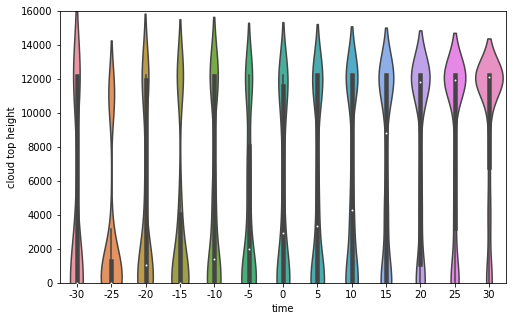

In [108]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax = sns.violinplot(x='time',y='cloud top height',data=cth_data)
ax.set_ylim(0,16000)

Text(0,0.5,u'A / km\xb2')

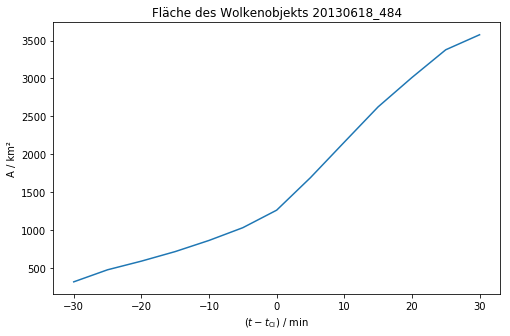

In [115]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(np.arange(-30,35,5),size)
ax.set_title(u"Fläche des Wolkenobjekts {}".format(track_id))
ax.set_xlabel(r"$(t - t_\mathrm{CI}$) / min")
ax.set_ylabel(u"A / km²")

In [112]:
size

[318, 477, 591, 717, 864, 1032, 1263, 1692, 2160, 2625, 3012, 3378, 3576]

/home/lenk/.local/lib/python2.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/lenk/.local/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'color'
  s)


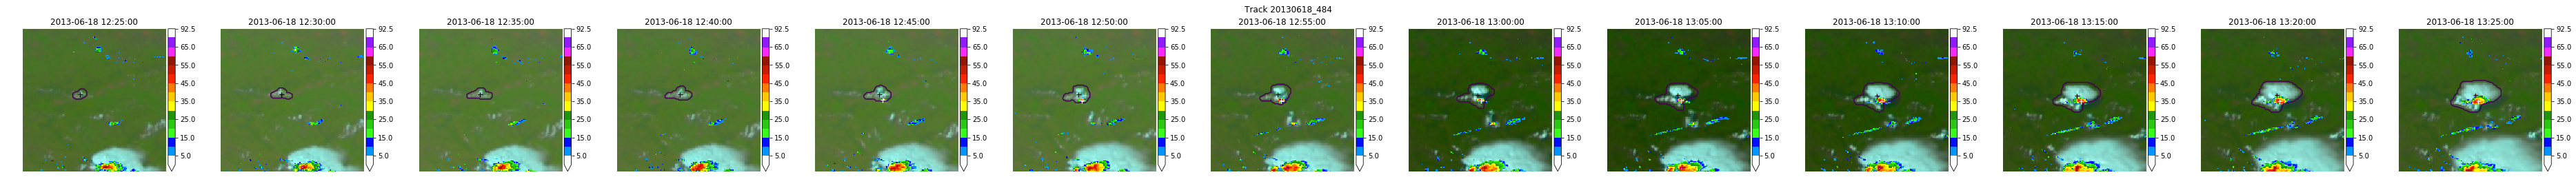

In [94]:
fig,ax = plt.subplots(1,13,figsize=(4*13,4))
axs=ax.ravel()
for i, n in enumerate(nc_rgbs):
    try:
        nc_plot =  ax[i].imshow(add_hrv_texture2nc(n,track_example.hrv.data[i]))
        ax[i].plot(centroids[i]['hrv'][1],centroids[i]['hrv'][0],'k+',mew=1.2,markersize=7)
        ax[i].contour(hrv_object[i],levels=[0.9],color='k')
    except:
        nc_plot =  ax[i].imshow(add_hrv_texture2nc(n,track_example.hrv.data[i]))
        
    ax[i].set_title(pd.to_datetime(track_example.time.data[i]))
    
    try:
        z_plot = ax[i].imshow(np.ma.masked_less_equal(np.ma.masked_greater(track_example.z.data[i],92),-32.5),
                                 cmap=rcmap,origin='upper',norm=rnorm)
        ax[i].plot(centroids[i]['rx'][1],centroids[i]['rx'][0],'w+',mew=1.2,markersize=7)
        fc.colourbar(z_plot)
    except:
        z_plot = ax[i].imshow(np.ma.masked_less_equal(np.ma.masked_greater_equal(track_example.z.data[i],92.5),-32.5),
                                 cmap=rcmap,origin='upper',norm=rnorm)
        fc.colourbar(z_plot)

    ax[i].axis("off")
    
fig.suptitle('Track {}'.format(track_id))
plt.tight_layout()
plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/track_overview/{}.png".format(track_id))

In [6]:
fig = plt.figure(figsize=(18,12))
grid = plt.GridSpec(3, 13, hspace=0.2, wspace=0.2)
#verlauf_ax = fig.add_subplot(grid[0,:])
for i, n in enumerate(nc_rgbs):
    v_ax = fig.add_subplot(grid[0,i])
    try:
        nc_plot =  v_ax.imshow(add_hrv_texture2nc(n,track_example.hrv.data[i]))
        v_ax.plot(centroids[i]['hrv'][1],centroids[i]['hrv'][0],'k+',mew=1.2,markersize=7)
        v_ax.contour(hrv_object[i],levels=[0.9],color='k')
    except:
        nc_plot =  v_ax.imshow(add_hrv_texture2nc(n,track_example.hrv.data[i]))

    v_ax.set_title(pd.to_datetime(track_example.time.data[i]).strftime("%H:%M"))

    try:
        z_plot = v_ax.imshow(np.ma.masked_less_equal(np.ma.masked_greater(track_example.z.data[i],92),-32.5),
                                 cmap=rcmap,origin='upper',norm=rnorm)
        v_ax.plot(centroids[i]['rx'][1],centroids[i]['rx'][0],'w+',mew=1.2,markersize=7)
        #fc.colourbar(z_plot)
    except:
        z_plot = v_ax[i].imshow(np.ma.masked_less_equal(np.ma.masked_greater_equal(track_example.z.data[i],92.5),-32.5),
                                 cmap=rcmap,origin='upper',norm=rnorm)
        #fc.colourbar(z_plot)

    v_ax.axis("off")

size_ax = fig.add_subplot(grid[1,0:6])
size_ax.plot(np.arange(-30,35,5),size)
size_ax.set_xlabel(r"$(t-t_\mathrm{CI}$ / min")
size_ax.set_ylabel(u"A / km²")
size_ax.set_title(u"Größe des Wolkenobjekts")

dist_ax = fig.add_subplot(grid[1,6:-1])
dist_ax.plot(np.arange(-30,35,5),distances.values())
dist_ax.set_xlabel(r"$(t-t_\mathrm{CI}$ / min")
dist_ax.set_ylabel(u"d / km")
dist_ax.set_title(u"Entfernung Wolke - Radar")

height_ax = fig.add_subplot(grid[2,:])
height_ax = sns.violinplot(x='time',y='cloud top height',data=cth_data)
height_ax.set_ylim(0,16000)
height_ax.set_ylabel(u"Wolkenoberkantenhöhe / m")
height_ax.set_xlabel(r"$(t-t_\mathrm{CI})$ / min")

fig.suptitle('Track {}'.format(track_id))
plt.tight_layout()
plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/track_overview/{}.png".format(track_id)) 

NameError: name 'nc_rgbs' is not defined

<Figure size 1296x864 with 0 Axes>

In [21]:
for tr in track_paths:
    track_id = get_track_id_from_file_path(tr)
    track_example = xr.open_dataset(tr)

    nc_rgbs = np.array([day_natural_composite(track_example.vis006.data[i],
                                            track_example.vis008.data[i],
                                            track_example.ir016.data[i],0.9,1.8) 
                        for i in xrange(len(track_example.ir108.data))])

    hrv_segmented = ot.segmentation_dilation(track_example.hrv.data,0.3,1) 
    main_track_hrv = ot.get_track_from_labeled_field(hrv_segmented)

    rx_segmented = ot.segmentation_dilation(track_example.z.data,35,gauss_sigma=0,dilation_size=3,op=operator.ge)
    main_track_rx = ot.get_track_from_labeled_field(rx_segmented)

    hrv_object = ot.get_wanted_object_field(hrv_segmented,main_track_hrv)
    rx_object = ot.get_wanted_object_field(rx_segmented,main_track_rx)

    centroids = {t:{'hrv':[],'rx':[]} for t in np.arange(0,13)}

    for t in np.arange(0,13):
        try:
            centroids[t]['hrv'] = ndi.measurements.center_of_mass(hrv_object[t])
        except:
            centroids[t]['hrv'] = (np.nan,np.nan)
            
        try:
            centroids[t]['rx'] = ndi.measurements.center_of_mass(rx_object[t])
        except:
            centroids[t]['rx'] = (np.nan,np.nan)  

    distances = dict()

    for t in centroids.keys():
        try:
            d = np.sqrt(((centroids[t]['hrv'][0] - centroids[t]['rx'][0])*2)**2 + \
                        (centroids[t]['hrv'][1] - centroids[t]['rx'][1])**2)
            distances[t] = d
        except:
            distances[t] = np.nan   

    cth = []
    t_idx =[]
    size = []

    for t in np.arange(0,13):
        obj_idx = np.where(hrv_object[t]!=0)
        
        ct = track_example.ct.data[t][obj_idx]
        not_cirrus_idx = np.where(ct<11)
        
        ch = track_example.cth.data[t][obj_idx]
        
        s = len(obj_idx[0])*2 + len(obj_idx[0])
        
        cth.extend(ch)
        size.append(s)
        t_idx.extend([-30+(t*5)]*len(ch))  


    cth_data = pd.DataFrame({'cloud top height':cth,'time':t_idx})


    fig = plt.figure(figsize=(32,20))
    grid = plt.GridSpec(3, 13, hspace=0.2, wspace=0.2)
    #verlauf_ax = fig.add_subplot(grid[0,:])
    for i, n in enumerate(nc_rgbs):
        v_ax = fig.add_subplot(grid[0,i])
        try:
            nc_plot =  v_ax.imshow(add_hrv_texture2nc(n,track_example.hrv.data[i]))
            v_ax.plot(centroids[i]['hrv'][1],centroids[i]['hrv'][0],'k+',mew=1.2,markersize=7)
            v_ax.contour(hrv_object[i],levels=[0.9])
        except:
            nc_plot =  v_ax.imshow(add_hrv_texture2nc(n,track_example.hrv.data[i]))

        v_ax.set_title(pd.to_datetime(track_example.time.data[i]).strftime("%H:%M"))

        try:
            z_plot = v_ax.imshow(np.ma.masked_less_equal(np.ma.masked_greater(track_example.z.data[i],92),1),
                                     cmap=rcmap,origin='upper',norm=rnorm)
            v_ax.plot(centroids[i]['rx'][1],centroids[i]['rx'][0],'w+',mew=1.2,markersize=7)
            #fc.colourbar(z_plot)
        except:
            z_plot = v_ax[i].imshow(np.ma.masked_less_equal(np.ma.masked_greater_equal(track_example.z.data[i],92.5),1),
                                     cmap=rcmap,origin='upper',norm=rnorm)
            #fc.colourbar(z_plot)

        v_ax.axis("off")

    size_ax = fig.add_subplot(grid[1,0:6])
    size_ax.plot(np.arange(-30,35,5),size)
    size_ax.set_xlabel(r"$(t-t_\mathrm{CI}$ / min")
    size_ax.set_ylabel(u"A / km²")
    size_ax.set_title(u"Größe des Wolkenobjekts")
    size_ax.set_xlim(-30,30)

    dist_ax = fig.add_subplot(grid[1,7:-1])
    dist_ax.plot(np.arange(-30,35,5),distances.values())
    dist_ax.set_xlabel(r"$(t-t_\mathrm{CI}$ / min")
    dist_ax.set_ylabel(u"d / km")
    dist_ax.set_title(u"Entfernung Wolke - Radar")
    dist_ax.set_xlim(-30,30)

    height_ax = fig.add_subplot(grid[2,:])
    height_ax = sns.violinplot(x='time',y='cloud top height',data=cth_data)
    height_ax.set_ylim(0,16000)
    height_ax.set_ylabel(u"Wolkenoberkantenhöhe / m")
    height_ax.set_xlabel(r"$(t-t_\mathrm{CI})$ / min")

    fig.suptitle('Track {}'.format(track_id))
    plt.tight_layout()
    plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/track_overview/{}.png".format(track_id)) 
    
    plt.close("all")

In [129]:
plt.close("all")

In [64]:
import numpy as np
import scipy.interpolate

old_grid_data=np.random.rand(4,3)

#old grid dim
loni=np.array([109.94999695, 110.05000305, 110.15000153])
depi=np.array([3.04677272, 9.45404911, 16.36396599, 23.89871025])

#new grid dim
lon=np.arange(110.,110.3,.1) #NB: 110.2 outside of convex hull of old so will produce nan
depth=np.array([3.1,9,16,23])

#create mesh
X, Y = np.meshgrid(loni, depi)
XI, YI = np.meshgrid(lon,depth)

#interp
new_grid=scipy.interpolate.griddata((X.flatten(),Y.flatten()),old_grid_data.flatten() , (XI,YI),method='cubic')

print "this is original"
print old_grid_data.reshape(4,3)
print ""
print "this is interp' by cubic"
print new_grid

print
print "this is diff"
print new_grid-old_grid_data.reshape(4,3)

this is original
[[0.29227139 0.95473485 0.59969002]
 [0.85543006 0.1753852  0.46838298]
 [0.03073767 0.04666775 0.95528493]
 [0.83467713 0.97238025 0.69520885]]

this is interp' by cubic
[[ 0.72194099  0.86895237         nan]
 [ 0.4625619   0.26005537         nan]
 [-0.04616664  0.40744328         nan]
 [ 0.78438564  0.76211379         nan]]

this is diff
[[ 0.4296696  -0.08578248         nan]
 [-0.39286816  0.08467017         nan]
 [-0.07690431  0.36077552         nan]
 [-0.05029148 -0.21026646         nan]]


In [77]:
z_new = [scipy.interpolate.griddata((track_example.rlon.data.flatten(),
                                     track_example.rlat.data.flatten()),
                                     z.flatten(),
                                    (track_example.hlon.data,track_example.hlat.data),method='linear')
         for z in track_example.z.data]

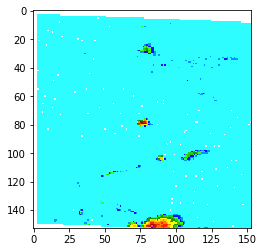

In [78]:
plt.imshow(z_new[6],cmap=rcmap,norm=rnorm)

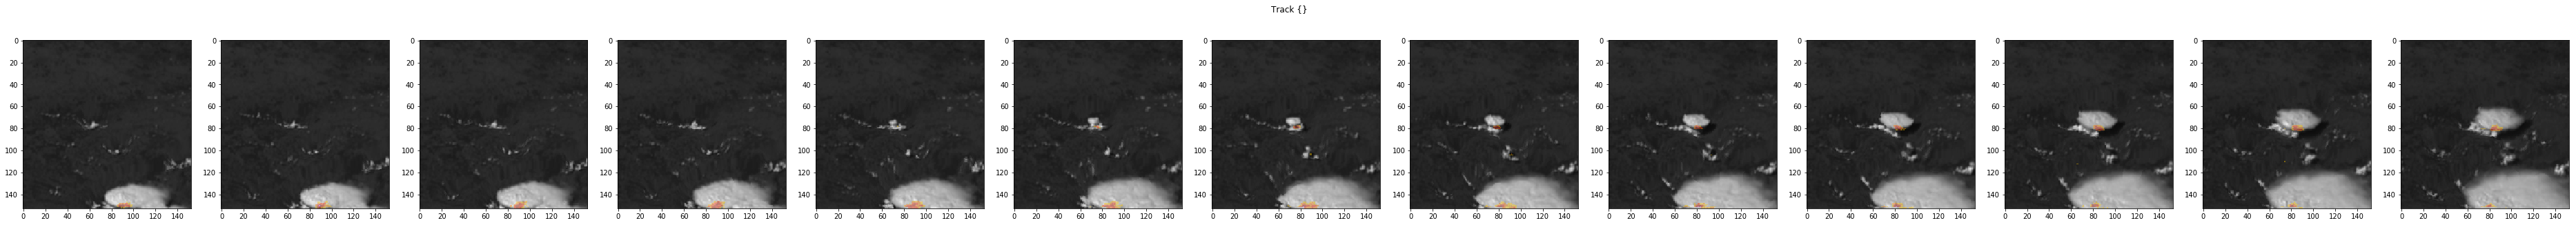

In [79]:
fig,ax = plt.subplots(1,13,figsize=(52,5))
axs=ax.ravel()
for i, n in enumerate(nc_rgbs):
    #ax[0,i].imshow(n)
    #nc_plot = ax[0,i].set_title(pd.to_datetime(track_example.time.data[i]))
    hrv_plot = ax[i].imshow(track_example.hrv.data[i],vmin=0,vmax=1,cmap='gray')
    z_plot = ax[i].imshow(np.ma.masked_less(z_new[i],35),cmap=rcmap,norm=rnorm,alpha=0.4)
    #fc.colourbar(z_plot)
fig.suptitle('Track {}')
plt.tight_layout()
plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/track_overview/{}.png".format(track_id))